In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# [1]. Load preprocessed data

In [13]:
final1 = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Amazon_fine_food_reviews/preprocessed_review_file.csv')

In [14]:
final1.head(2)

,Unnamed: 0,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,preprocessed_reviews
0,150523,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...
1,150505,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew reading sendak books watching really rosi...


In [15]:
final1.shape

(11000, 12)

In [16]:
final1.dropna(axis=0, inplace=True)

In [17]:
final1.shape

(10975, 12)

In [18]:
final2 = final1.head(5000)

In [19]:
preprocessed_reviews = final2['preprocessed_reviews']

In [20]:
type(preprocessed_reviews)

pandas.core.series.Series

In [21]:
len(preprocessed_reviews)

5000

In [22]:
score = final2['Score']
print(len(score))

5000


In [23]:
np.unique(score, return_counts=True)

(array([0, 1]), array([ 889, 4111]))

# [4]. Train test split

In [24]:
from sklearn.model_selection import StratifiedShuffleSplit

In [25]:
preprocessed_reviews = preprocessed_reviews.values.reshape(-1,1)

In [26]:
preprocessed_reviews.shape

(5000, 1)

In [27]:
score = score.values.reshape(-1,1)

In [28]:
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.33, random_state=3)

for train_idx, test_idx in sss.split(X=preprocessed_reviews, y=score):
    # print("TRAIN:", train_idx, "TEST:", test_idx)
    x_train, x_test_all = preprocessed_reviews[train_idx], preprocessed_reviews[test_idx]
    y_train, y_test_all = score[train_idx], score[test_idx]

In [29]:
x_test_all = x_test_all.reshape(-1, 1)
y_test_all = y_test_all.reshape(-1, 1)

In [30]:
print(x_test_all.shape)
print(y_test_all.shape)

(1650, 1)
(1650, 1)


In [31]:
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.5, random_state=3)

for train_idx, test_idx in sss.split(X=x_test_all, y=y_test_all):
    # print("TRAIN:", train_idx, "TEST:", test_idx)
    x_cv, x_test = x_test_all[train_idx], x_test_all[test_idx]
    y_cv, y_test = y_test_all[train_idx], y_test_all[test_idx]

In [32]:
print(x_train.shape)
print(y_train.shape)
print(x_cv.shape)
print(y_cv.shape)
print(x_test.shape)
print(y_test.shape)

(3350, 1)
(3350, 1)
(825, 1)
(825, 1)
(825, 1)
(825, 1)


In [33]:
x_train = pd.Series((v[0] for v in x_train))
x_cv = pd.Series((v[0] for v in x_cv))
x_test = pd.Series((v[0] for v in x_test))

# [5]. Featurization

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

### [5.1]. Bag of Words

In [35]:
x_train

0       really love cinnamon able eat sugar free cinna...
1       best friend turned cavender back use many reci...
2       ordering lot many go directly daughter house l...
3       started cake decorating first professional col...
4       husband loves noodles mother used make happy f...
                              ...                        
3345    liguria italy best climate region olive oil ca...
3346    recently purchased item recipe not taste horri...
3347    no complaints plant came time perfectly packed...
3348    dog really likes treats use training pretty sm...
3349    wanted cat friendly garden rooftop deck cat pl...
Length: 3350, dtype: object

In [36]:
count_vect = CountVectorizer(min_df=10, max_features=500)
count_vect.fit(x_train)
print("some feature names :", count_vect.get_feature_names()[:10])
print("="*50)

bow_train_counts = count_vect.transform(x_train)
bow_cv_counts = count_vect.transform(x_cv)
bow_test_counts = count_vect.transform(x_test)

print(type(bow_train_counts))
print(bow_train_counts.get_shape())
print(bow_train_counts.get_shape()[1])

some feature names : ['able', 'absolutely', 'actually', 'add', 'added', 'ago', 'almost', 'already', 'also', 'although']
<class 'scipy.sparse.csr.csr_matrix'>
(3350, 500)
500


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### [5.2]. Bi-Grams and n-grams

In [37]:
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=500)
x_train_bigrams_counts = count_vect.fit_transform(x_train)
x_cv_bigrams_counts = count_vect.transform(x_cv)
x_test_bigrams_counts = count_vect.transform(x_test)

print(type(x_train_bigrams_counts))
print(x_train_bigrams_counts.get_shape())
print(x_train_bigrams_counts.get_shape()[1])

<class 'scipy.sparse.csr.csr_matrix'>
(3350, 500)
500


### [5.3]. TF-IDF

In [38]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=500)
tf_idf_vect.fit(x_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

x_train_tf_idf = tf_idf_vect.transform(x_train)
x_cv_tf_idf = tf_idf_vect.transform(x_cv)
x_test_tf_idf = tf_idf_vect.transform(x_test)

print("the type of count vectorizer ",type(x_train_tf_idf))
print("the shape of out text TFIDF vectorizer ",x_train_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", x_train_tf_idf.get_shape()[1])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


some sample features(unique words in the corpus) ['able', 'absolutely', 'actually', 'add', 'added', 'ago', 'almost', 'already', 'also', 'although']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (3350, 500)
the number of unique words including both unigrams and bigrams  500


### [5.4]. Word2Vec

In [39]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentence_train = [sentence.split() for sentence in x_train]
list_of_sentence_cv = [sentence.split() for sentence in x_cv]
list_of_sentence_test = [sentence.split() for sentence in x_test]

In [40]:
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentence_train,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('wonderful', 0.9990211725234985), ('good', 0.9988526701927185), ('tasted', 0.9987857937812805), ('sweet', 0.9987848997116089), ('tastes', 0.9987680315971375), ('adds', 0.9987635016441345), ('pepper', 0.9987601041793823), ('delicious', 0.9987429976463318), ('enjoy', 0.9987311959266663), ('makes', 0.9986861944198608)]
[('son', 0.9995877742767334), ('special', 0.9995777010917664), ('please', 0.9995741248130798), ('thank', 0.9995718002319336), ('near', 0.9995698928833008), ('medium', 0.9995575547218323), ('helps', 0.9995534420013428), ('instead', 0.9995511770248413), ('e', 0.9995501637458801), ('either', 0.9995473027229309)]


In [41]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3703
sample words  ['really', 'love', 'cinnamon', 'able', 'eat', 'sugar', 'free', 'candy', 'tastes', 'like', 'not', 'great', 'best', 'friend', 'turned', 'cavender', 'back', 'use', 'many', 'recipes', 'would', 'lost', 'without', 'goes', 'salad', 'pasta', 'veggies', 'meats', 'soups', 'ok', 'never', 'used', 'dessert', 'recipe', 'east', 'coast', 'two', 'months', 'thing', 'made', 'sure', 'pack', 'size', 'introduced', 'people', 'seasoning', 'secret', 'ingredient', 'popular', 'making']


### [5.5]. Converting text into vectors using wAvg W2V

In [42]:
from tqdm import tqdm

In [43]:
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
sent_vectors_cv = [];
sent_vectors_test = [];

for i, aset in enumerate([list_of_sentence_train, list_of_sentence_cv, list_of_sentence_test]): # for each review/sentence
    if i==0:
        print("working on training set")
    elif i==1:
        print("working on validation set")
    elif i==2:
        print("working on test set")
    for sent in aset:
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        if i==0:
            sent_vectors_train.append(sent_vec)
        elif i==1:
            sent_vectors_cv.append(sent_vec)
        elif i==2:
            sent_vectors_test.append(sent_vec)

print("Sentence vectors created")
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

working on training set
working on validation set
working on test set
Sentence vectors created
3350
50


### [5.5]. Convert text into vectors using TFIDF-W2V

In [44]:
model = TfidfVectorizer(min_df=10, max_features=500)
tf_idf_matrix = model.fit_transform(x_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [45]:
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train, tfidf_sent_vectors_cv, tfidf_sent_vectors_test = [], [], []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for i, aset in enumerate([list_of_sentence_train, list_of_sentence_cv, list_of_sentence_test]): # for each review/sentence 
    if i==0:
        print("working on training set")
    elif i==1:
        print("working on validation set")
    elif i==2:
        print("working on test set")
    for sent in aset:
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        if i==0:
            tfidf_sent_vectors_train.append(sent_vec)
        elif i==1:
            tfidf_sent_vectors_cv.append(sent_vec)
        elif i==2:
            tfidf_sent_vectors_test.append(sent_vec)
        row += 1

print("Sentence vectors created")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


working on training set
working on validation set
working on test set
Sentence vectors created


# [6] Assignment 3: KNN

<ol>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 5:</font>Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.
            <pre>
            count_vect = CountVectorizer(min_df=10, max_features=500) 
            count_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 6:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'> link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying KNN brute force

In [53]:
import warnings
warnings.filterwarnings("ignore")

In [49]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [50]:
def knn_classifier(x_train, y_train, x_test, y_test, algoType):
    train_auc, test_auc = [], []
    cv_score = []
    conf_mat = []

    kneighbors = [1, 3, 5, 7, 10, 15, 19, 25]
    for k in kneighbors:
        print("Progress: "+str(int((k*100)/51))+"%      ", end='\r')
        knn = KNeighborsClassifier(n_neighbors=k, algorithm=algoType, n_jobs=-1)
        knn.fit(x_train, y_train)

        train_auc.append(roc_auc_score(y_train, knn.predict_proba(x_train)[:, 1]))
        test_auc.append(roc_auc_score(y_test, knn.predict_proba(x_test)[:, 1]))

        scores = cross_val_score(knn, x_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
        cv_score.append(1-scores.mean())

    print("Progress: 100%       ")

    plt.figure(figsize=(10,8))
    plt.plot(kneighbors, train_auc, label='Train AUC')
    plt.plot(kneighbors, test_auc, label='CV AUC')
    plt.legend()
    plt.xlabel("K: Hyperparamter")
    plt.ylabel("AUC")
    plt.title("Model evaluation plot for KNN")
    plt.show()

    return kneighbors[cv_score.index(min(cv_score))]


In [51]:
def draw_confusion_matrix(actual, predicted):
    class_label = ['negative', 'positive']
    conf_matrix = confusion_matrix(actual, predicted)
    df_cm = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
    hm = sns.heatmap(df_cm, annot=True, fmt='d')
    plt.xlabel('Predicted label')
    plt.ylabel('Actual Label')
    plt.show()

### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

Progress: 100%       


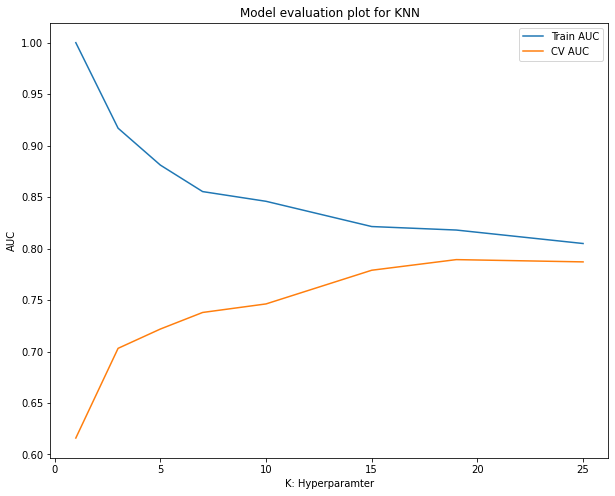

Optimal K value for BOW is:  15


In [54]:
optimalK_bow = knn_classifier(bow_train_counts, y_train, bow_cv_counts, y_cv, 'brute')
print("Optimal K value for BOW is: ", optimalK_bow)

Using k value in kNN -  15
Train accuracy for optimal kNN using BOW 84.36
Test accuracy for optimal kNN using BOW 83.64


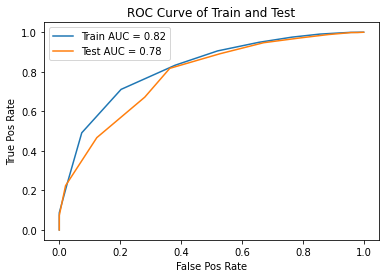

In [55]:
knn_optimal_bow = KNeighborsClassifier(n_neighbors=optimalK_bow, algorithm='brute')
knn_optimal_bow.fit(bow_train_counts, y_train)

# Prediction on training and test set using optimal
pred_bow_train = knn_optimal_bow.predict(bow_train_counts)
pred_bow_test = knn_optimal_bow.predict(bow_test_counts)
print("Using k value in kNN - ", optimalK_bow)
print("Train accuracy for optimal kNN using BOW", round(accuracy_score(y_train, pred_bow_train)*100, 2))
print("Test accuracy for optimal kNN using BOW", round(accuracy_score(y_test, pred_bow_test) * 100, 2))

# ROC-AUC on train & test data
train_fpr, train_tpr, thresholds = roc_curve(y_train, knn_optimal_bow.predict_proba(bow_train_counts)[:, 1], pos_label=1)
test_fpr, test_tpr, thresholds = roc_curve(y_test, knn_optimal_bow.predict_proba(bow_test_counts)[:, 1], pos_label=1)
# Draw ROC curve
plt.plot(train_fpr, train_tpr, label="Train AUC = "+str(round(auc(train_fpr, train_tpr), 2)))
auc_score = round(auc(test_fpr, test_tpr), 2)
plt.plot(test_fpr, test_tpr, label="Test AUC = "+str(auc_score))
plt.legend()
plt.xlabel("False Pos Rate")
plt.ylabel("True Pos Rate")
plt.title("ROC Curve of Train and Test")
plt.show()

In [61]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names= ["Vectorizer", "Model", "Hyperparameters", "AUC Score"]

Training Confusion Matrix


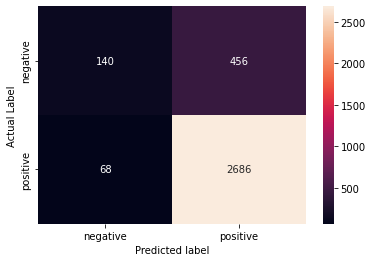




Test Confusion Matrix


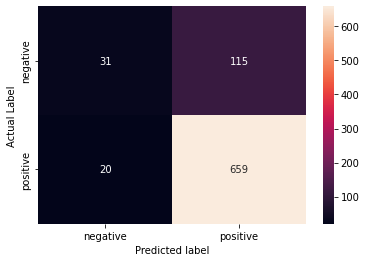

In [62]:
print("Training Confusion Matrix")
draw_confusion_matrix(y_train, pred_bow_train)
print('\n\n')

print("Test Confusion Matrix")
draw_confusion_matrix(y_test, pred_bow_test)
table.add_row(["BOW", "Brute", optimalK_bow, auc_score])

In [64]:
print(classification_report(y_test, pred_bow_test))

              precision    recall  f1-score   support

           0       0.61      0.21      0.31       146
           1       0.85      0.97      0.91       679

    accuracy                           0.84       825
   macro avg       0.73      0.59      0.61       825
weighted avg       0.81      0.84      0.80       825



### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

Progress: 100%       


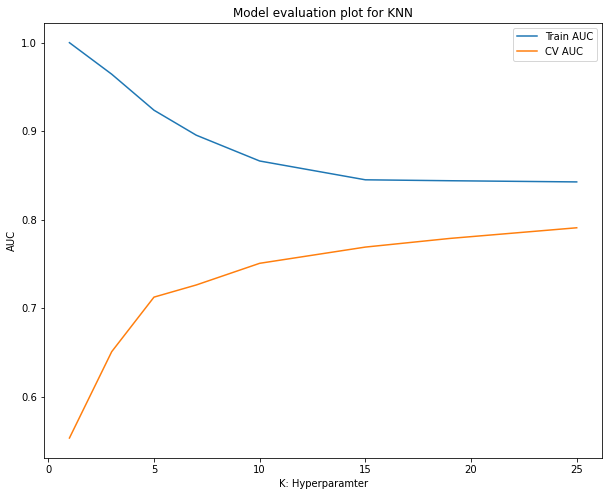

Optimal K value for Tf-IDF is :  25


In [65]:
optimalK_tfIdf = knn_classifier(x_train_tf_idf, y_train, x_cv_tf_idf, y_cv, 'brute')
print("Optimal K value for Tf-IDF is : ", optimalK_tfIdf)

Using k value in kNN -  25
Train accuracy for optimal kNN using TFIDF 83.79
Test accuracy for optimal kNN using TFIDF 83.64


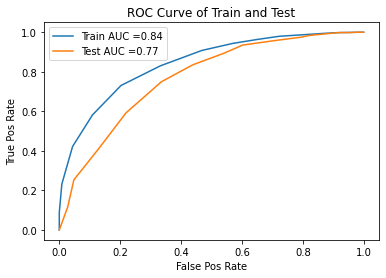

In [67]:
knn_optimal_tf = KNeighborsClassifier(n_neighbors=optimalK_tfIdf, algorithm='brute')
knn_optimal_tf.fit(x_train_tf_idf, y_train)

# Prediction on training and test set using optimal
pred_tfIdf_train = knn_optimal_tf.predict(x_train_tf_idf)
pred_tfIdf_test = knn_optimal_tf.predict(x_test_tf_idf)
print("Using k value in kNN - ", optimalK_tfIdf)
print("Train accuracy for optimal kNN using TFIDF", round(accuracy_score(y_train, pred_tfIdf_train)*100, 2))
print("Test accuracy for optimal kNN using TFIDF", round(accuracy_score(y_test, pred_tfIdf_test) * 100, 2))

# ROC-AUC on train & test data
train_fpr, train_tpr, thresholds = roc_curve(y_train, knn_optimal_tf.predict_proba(x_train_tf_idf)[:, 1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, knn_optimal_tf.predict_proba(x_test_tf_idf)[:, 1])
# Draw ROC curve
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(round(auc(train_fpr, train_tpr), 2)))
auc_score = round(auc(test_fpr, test_tpr), 2)
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc_score))
plt.legend()
plt.xlabel("False Pos Rate")
plt.ylabel("True Pos Rate")
plt.title("ROC Curve of Train and Test")
plt.show()

Training Confusion Matrix


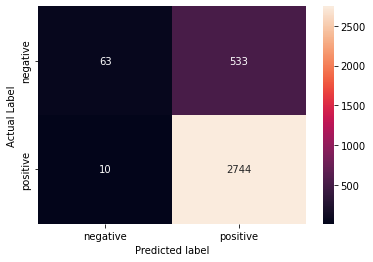




Test Confusion Matrix


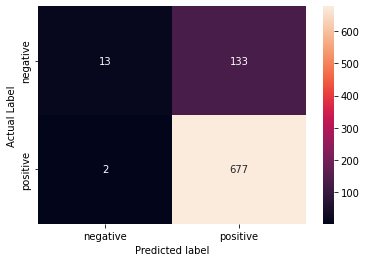

In [68]:
print("Training Confusion Matrix")
draw_confusion_matrix(y_train, pred_tfIdf_train)
print('\n\n')

print("Test Confusion Matrix")
draw_confusion_matrix(y_test, pred_tfIdf_test)
table.add_row(["Tf-Idf", "Brute", optimalK_tfIdf, auc_score])

In [69]:
print(classification_report(y_test, pred_tfIdf_test))

              precision    recall  f1-score   support

           0       0.87      0.09      0.16       146
           1       0.84      1.00      0.91       679

    accuracy                           0.84       825
   macro avg       0.85      0.54      0.54       825
weighted avg       0.84      0.84      0.78       825



### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

In [ ]:
# Please write all the code with proper documentation

Progress: 100%       


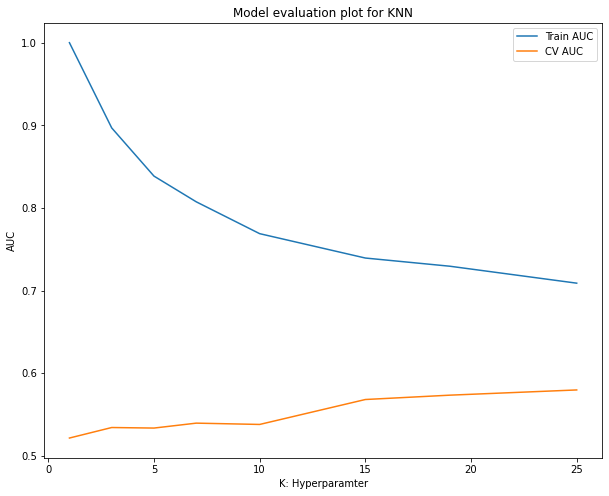

Optimal K value for Avg W2V is :  19


In [71]:
optimalK_avgWV = knn_classifier(sent_vectors_train, y_train, sent_vectors_cv, y_cv, 'brute')
print("Optimal K value for Avg W2V is : ", optimalK_avgWV)

Using k value in kNN -  19
Train accuracy for optimal kNN using AvgW2V 82.03
Test accuracy for optimal kNN using AvgW2V 82.3


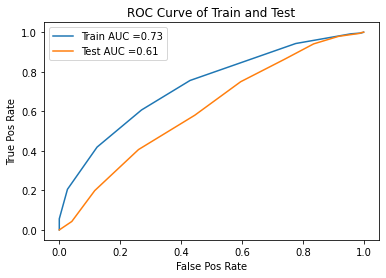

In [74]:
knn_optimal_avw2v = KNeighborsClassifier(n_neighbors=optimalK_avgWV, algorithm='brute')
knn_optimal_avw2v.fit(sent_vectors_train, y_train)

# Prediction on training and test set using optimal
pred_avw2v_train = knn_optimal_avw2v.predict(sent_vectors_train)
pred_avw2v_test = knn_optimal_avw2v.predict(sent_vectors_test)
print("Using k value in kNN - ", optimalK_avgWV)
print("Train accuracy for optimal kNN using AvgW2V", round(accuracy_score(y_train, pred_avw2v_train)*100, 2))
print("Test accuracy for optimal kNN using AvgW2V", round(accuracy_score(y_test, pred_avw2v_test) * 100, 2))

# ROC-AUC on train & test data
train_fpr, train_tpr, thresholds = roc_curve(y_train, knn_optimal_avw2v.predict_proba(sent_vectors_train)[:, 1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, knn_optimal_avw2v.predict_proba(sent_vectors_test)[:, 1])
# Draw ROC curve
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(round(auc(train_fpr, train_tpr), 2)))
auc_score = round(auc(test_fpr, test_tpr), 2)
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc_score))
plt.legend()
plt.xlabel("False Pos Rate")
plt.ylabel("True Pos Rate")
plt.title("ROC Curve of Train and Test")
plt.show()

Training Confusion Matrix


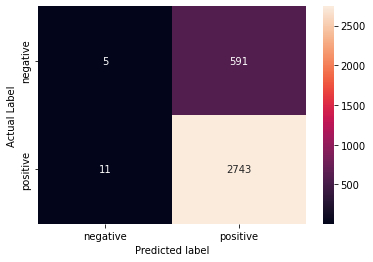




Test Confusion Matrix


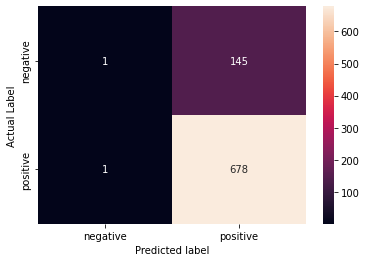

In [75]:
print("Training Confusion Matrix")
draw_confusion_matrix(y_train, pred_avw2v_train)
print('\n\n')

print("Test Confusion Matrix")
draw_confusion_matrix(y_test, pred_avw2v_test)
table.add_row(["Avg Word2Vec", "Brute", optimalK_avgWV, auc_score])

In [76]:
print(classification_report(y_test, pred_avw2v_test))

              precision    recall  f1-score   support

           0       0.50      0.01      0.01       146
           1       0.82      1.00      0.90       679

    accuracy                           0.82       825
   macro avg       0.66      0.50      0.46       825
weighted avg       0.77      0.82      0.75       825



### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

In [ ]:
# Please write all the code with proper documentation

Progress: 100%       


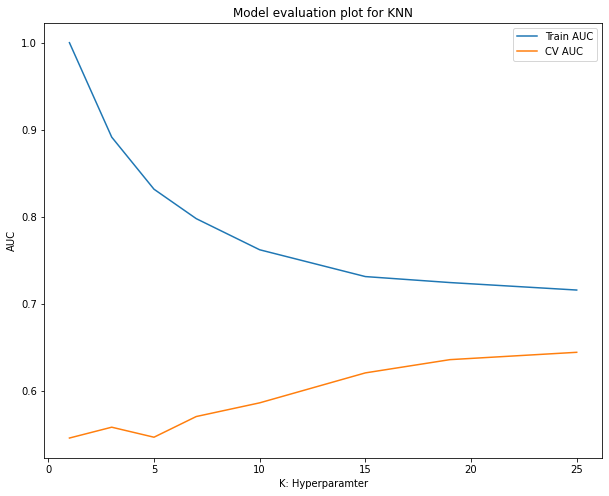

Optimal K value for Tf-IDF W2V is :  25


In [78]:
optimalK_tfIdfWV = knn_classifier(tfidf_sent_vectors_train, y_train, tfidf_sent_vectors_cv, y_cv, 'brute')
print("Optimal K value for Tf-IDF W2V is : ", optimalK_tfIdfWV)

Using k value in kNN -  25
Train accuracy for optimal kNN using TfIDF-W2V 82.27
Test accuracy for optimal kNN using TfIDF-W2V 82.67


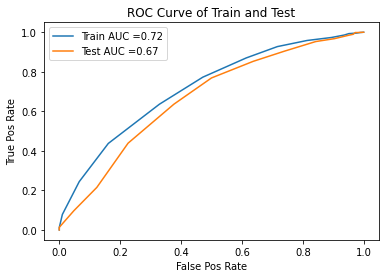

In [79]:
knn_optimal_tfIdfWV = KNeighborsClassifier(n_neighbors=optimalK_tfIdfWV, algorithm='brute')
knn_optimal_tfIdfWV.fit(tfidf_sent_vectors_train, y_train)

# Prediction on training and test set using optimal
pred_tfIdfWV_train = knn_optimal_tfIdfWV.predict(tfidf_sent_vectors_train)
pred_tfIdfWV_test = knn_optimal_tfIdfWV.predict(tfidf_sent_vectors_test)
print("Using k value in kNN - ", optimalK_tfIdfWV)
print("Train accuracy for optimal kNN using TfIDF-W2V", round(accuracy_score(y_train, pred_tfIdfWV_train)*100, 2))
print("Test accuracy for optimal kNN using TfIDF-W2V", round(accuracy_score(y_test, pred_tfIdfWV_test) * 100, 2))

# ROC-AUC on train & test data
train_fpr, train_tpr, thresholds = roc_curve(y_train, knn_optimal_tfIdfWV.predict_proba(tfidf_sent_vectors_train)[:, 1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, knn_optimal_tfIdfWV.predict_proba(tfidf_sent_vectors_test)[:, 1])
# Draw ROC curve
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(round(auc(train_fpr, train_tpr), 2)))
auc_score = round(auc(test_fpr, test_tpr), 2)
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc_score))
plt.legend()
plt.xlabel("False Pos Rate")
plt.ylabel("True Pos Rate")
plt.title("ROC Curve of Train and Test")
plt.show()

Training Confusion Matrix


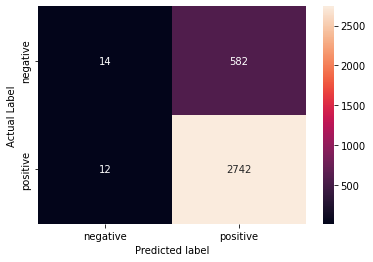




Test Confusion Matrix


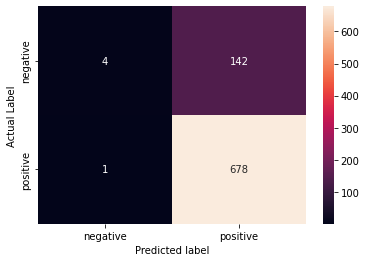

In [80]:
print("Training Confusion Matrix")
draw_confusion_matrix(y_train, pred_tfIdfWV_train)
print('\n\n')

print("Test Confusion Matrix")
draw_confusion_matrix(y_test, pred_tfIdfWV_test)
table.add_row(["Tf-IDF Word2Vec", "Brute", optimalK_tfIdfWV, auc_score])

In [81]:
print(classification_report(y_test, pred_tfIdfWV_test))

              precision    recall  f1-score   support

           0       0.80      0.03      0.05       146
           1       0.83      1.00      0.90       679

    accuracy                           0.83       825
   macro avg       0.81      0.51      0.48       825
weighted avg       0.82      0.83      0.75       825



## [5.2] Applying KNN kd-tree

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

In [ ]:
# Please write all the code with proper documentation

### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

In [ ]:
# Please write all the code with proper documentation

### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>

In [ ]:
# Please write all the code with proper documentation

### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

In [ ]:
# Please write all the code with proper documentation

# [6] Conclusions

In [ ]:
# Please compare all your models using Prettytable library